In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
import sys
sys.path.append("../../")
from src.util import noise_generator
from src.util import bath_correlation_function
from src.util import debye_spectral_density
from tqdm.notebook import tqdm

We need a complex stochastic process $z_t$, such that the following holds:
\begin{equation}
    \mathbb{E}\left[ z_t \right]=0,
\end{equation}
\begin{equation}
    \mathbb{E}\left[ z_t z_s \right]=\mathbb{E}\left[ z_t^* z_s^* \right]=0,
\end{equation}
\begin{equation}
    \mathbb{E}\left[ z_t z_s^* \right]=\alpha(t-s)
\end{equation}
where $\alpha(\tau)$ is the bath correlation functoin (BCF). In this notebook we test the three classes implemented in the file `noise_generator.py`.

### Helper functions for the analysis of the noise

In [3]:
# Computes the mean, mean of correlation, and mean of conjugate correlation and plots them.
def perform_noise_analysis(sample, ts, N_steps, N_samples_list, g, w, print_progress=True):
    # generate processes
    processes = []
    for i, N_samples in enumerate(N_samples_list):
        start_time = time.time()
        processes.append(np.empty((N_samples, N_steps), dtype=complex))
        for j in range(N_samples):
            processes[i][j, :] = sample()
            # print progress
            if print_progress and j%(N_samples//10) == 0:
                print(j)
        end_time = time.time()
        print("finished generating", N_samples, "samples in", end_time-start_time, "seconds!")
    print("Starting analysis ...")
    # analyze and plot
    fig, axarray = plt.subplots(3, 2, figsize=(14, 20))
    theoretical_covariance = bath_correlation_function.alpha(ts, g, w)
    # compute and plot mean
    for i, N_samples in enumerate(N_samples_list):
        mean = np.mean(processes[i], axis=0)
        axarray[0, 0].plot(ts, np.real(mean), label=str(N_samples)+" processes")
        axarray[0, 1].plot(ts, np.imag(mean), label=str(N_samples)+" processes")
    axarray[0, 0].set_title("real part of the mean")
    axarray[0, 1].set_title("imaginary part of the mean")
    axarray[0, 0].legend()
    axarray[0, 1].legend()
    # compute and plot mean of correlation
    for i, N_samples in enumerate(N_samples_list):
        valueAtZero = processes[i][:, 0]
        variance = np.mean(processes[i] * valueAtZero[:, np.newaxis], axis=0)
        axarray[1, 0].plot(ts, np.real(variance), label=str(N_samples)+" processes")
        axarray[1, 1].plot(ts, np.imag(variance), label=str(N_samples)+" processes")
    axarray[1, 0].set_title("real part of the variance")
    axarray[1, 1].set_title("imaginary part of the variance")
    axarray[1, 0].legend()
    axarray[1, 1].legend()
    # compute and plot mean of conjugate correlation
    for i, N_samples in enumerate(N_samples_list):
        valueAtZero = np.conj(processes[i][:, 0])
        variance = np.mean(processes[i] * valueAtZero[:, np.newaxis], axis=0)
        axarray[2, 0].plot(ts, np.real(variance), label=str(N_samples)+" processes")
        axarray[2, 1].plot(ts, np.imag(variance), label=str(N_samples)+" processes")
    axarray[2, 0].plot(ts, np.real(theoretical_covariance), "--", label="theory")
    axarray[2, 1].plot(ts, np.imag(theoretical_covariance), "--", label="theory")
    axarray[2, 0].set_title("real part of the conjugate variance")
    axarray[2, 1].set_title("imaginary part of the conjugate variance")
    axarray[2, 0].legend()
    axarray[2, 1].legend()

# Generating noise for a BCF with one mode

We will start by looking at the simple BCF which is used for the first example (spin-boson model) in the original HOPS paper:

\begin{equation}
    \alpha(\tau) = g e^{-\omega\tau}
\end{equation}
with
\begin{equation}
g = 2
\end{equation}
and
\begin{equation}
\omega = 0.5 + 2i
\end{equation}

In [4]:
g = np.array([2])
w = np.array([0.5+2j])
t_start = 0
t_stop = 10

## Multivariate Gaussian

Writing $z_t=x_t+iy_t$ and multiplying out, one immediately ends up with three equations:
\begin{equation}
\tag{1}
    \mathbb{E}\left[ z_t z_s \right] = \mathbb{E}\left[ x_t x_s \right] - \mathbb{E}\left[ y_t y_s \right] + i\left(\mathbb{E}\left[ x_t y_s \right] + \mathbb{E}\left[ y_t x_s \right]\right) \stackrel{!}{=} 0,
\end{equation}
\begin{equation}
\tag{2}
    \mathbb{E}\left[ z_t^* z_s^* \right] = \mathbb{E}\left[ x_t x_s \right] - \mathbb{E}\left[ y_t y_s \right] - i\left(\mathbb{E}\left[ x_t y_s \right] + \mathbb{E}\left[ y_t x_s \right]\right) \stackrel{!}{=} 0,
\end{equation}
\begin{equation}
\tag{3}
    \mathbb{E}\left[ z_t z_s* \right] = \mathbb{E}\left[ x_t x_s \right] + \mathbb{E}\left[ y_t y_s \right] - i\left(\mathbb{E}\left[ x_t y_s \right] - \mathbb{E}\left[ y_t x_s \right]\right) \stackrel{!}{=} \alpha(t-s).
\end{equation}

With a bit of calculus one can easily see that
\begin{equation}
    \mathbb{E}\left[ x_t x_s \right] \stackrel{!}{=} \mathbb{E}\left[ y_t y_s \right] \stackrel{!}{=} \frac{1}{2}\Re\left(\alpha(t-s)\right)
\end{equation}
and
\begin{equation}
    \mathbb{E}\left[ x_t y_s \right] \stackrel{!}{=} -\mathbb{E}\left[ y_t x_s \right] \stackrel{!}{=} -\frac{1}{2}\Im\left(\alpha(t-s)\right).
\end{equation}
With this in mind we can generate a real-valued gaussian process
\begin{equation}
    \left(x_0, y_0, x_1, y_1, \dots, x_{N_{\text{steps}-1}}, y_{N_{\text{steps}-1}}\right)
\end{equation}
with the covariance matrix $C$, defined as:
\begin{equation}
    C_{2i,2j} = C_{2i+1,2j+1} = \frac{1}{2}\Re\left(\alpha(t_i-t_j)\right),
\end{equation}
\begin{equation}
    C_{2i,2j+1} = -C_{2i+1,2j} = -\frac{1}{2}\Im\left(\alpha(t_i-t_j)\right).
\end{equation}
The time values $t_i$ and $t_j$ are taken from a list of discrete time values. 

In [5]:
N_steps = 200
ts = np.linspace(t_start, t_stop, N_steps)

In [6]:
alpha = lambda tau: bath_correlation_function.alpha(tau, g, w)
generator = noise_generator.ColoredNoiseGenerator_Gaussian(ts, alpha)

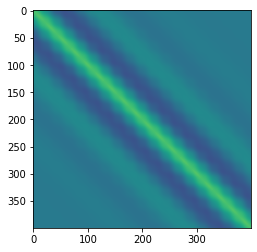

In [7]:
plt.imshow(generator.cov_matrix)
plt.show()

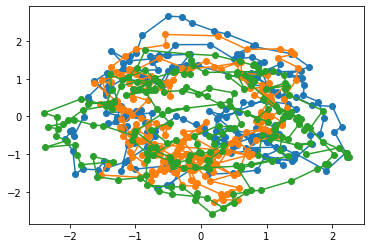

In [8]:
N_samples = 3
for _ in range(N_samples):
    process = generator.sample_process()
    plt.plot(np.real(process), np.imag(process), "o-")
plt.show()

finished generating 100 samples in 6.527104616165161 seconds!
finished generating 1000 samples in 61.95473098754883 seconds!
Starting analysis ...


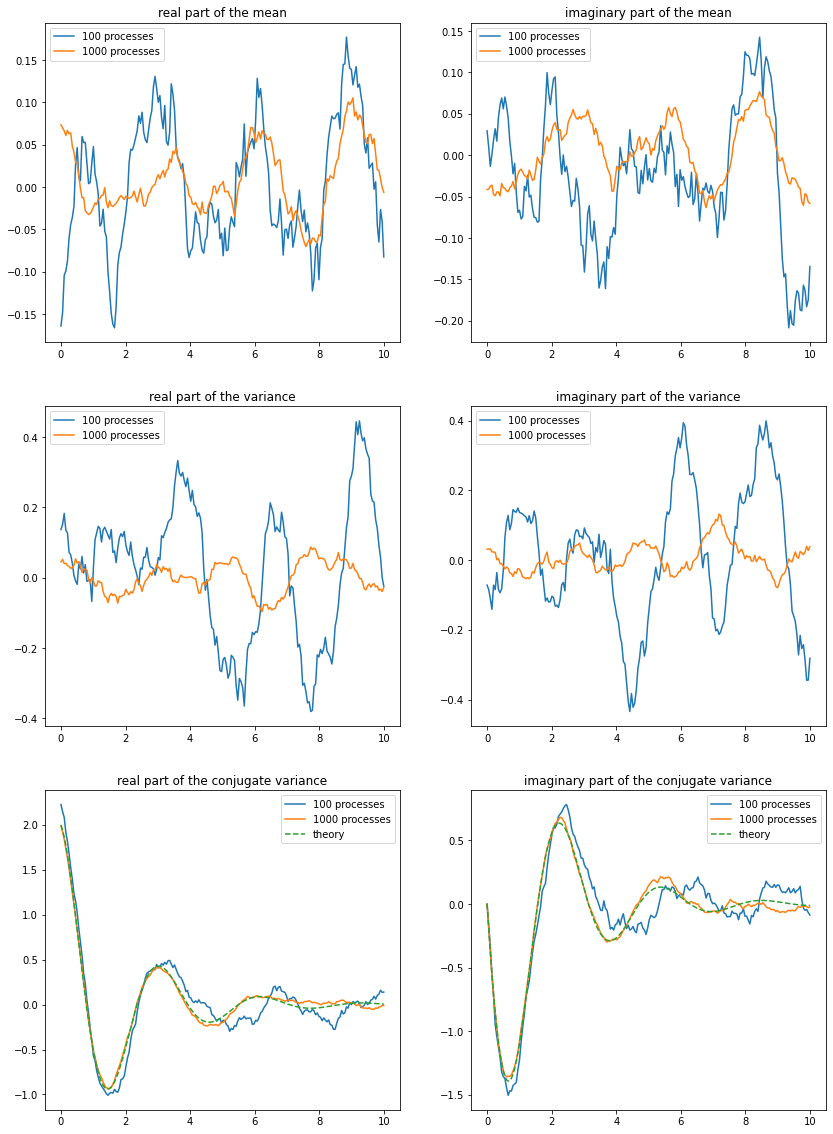

In [9]:
sample = lambda : generator.sample_process()
perform_noise_analysis(sample, ts, N_steps, [100, 1000], g, w, False)

Mean and Mean of variance approach zero. Mean of conjugate variances matches the desired variance very well! This is however very slow ...

## Fourier filtering

In [10]:
N_steps = 200
ts = np.linspace(t_start, t_stop, N_steps)

In [11]:
alpha = lambda tau: bath_correlation_function.alpha(tau, g, w)
generator = noise_generator.ColoredNoiseGenerator_FourierFiltering(alpha, t_start, t_stop)
generator.initialize(N_steps)

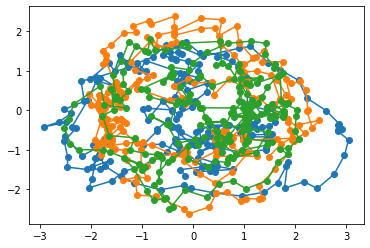

In [12]:
N_samples = 3
for _ in range(N_samples):
    process = generator.sample_process()
    plt.plot(np.real(process), np.imag(process), "o-")
plt.show()

finished generating 100 samples in 0.004124641418457031 seconds!
finished generating 1000 samples in 0.0399014949798584 seconds!
finished generating 10000 samples in 0.40169692039489746 seconds!
finished generating 100000 samples in 3.905027151107788 seconds!
Starting analysis ...


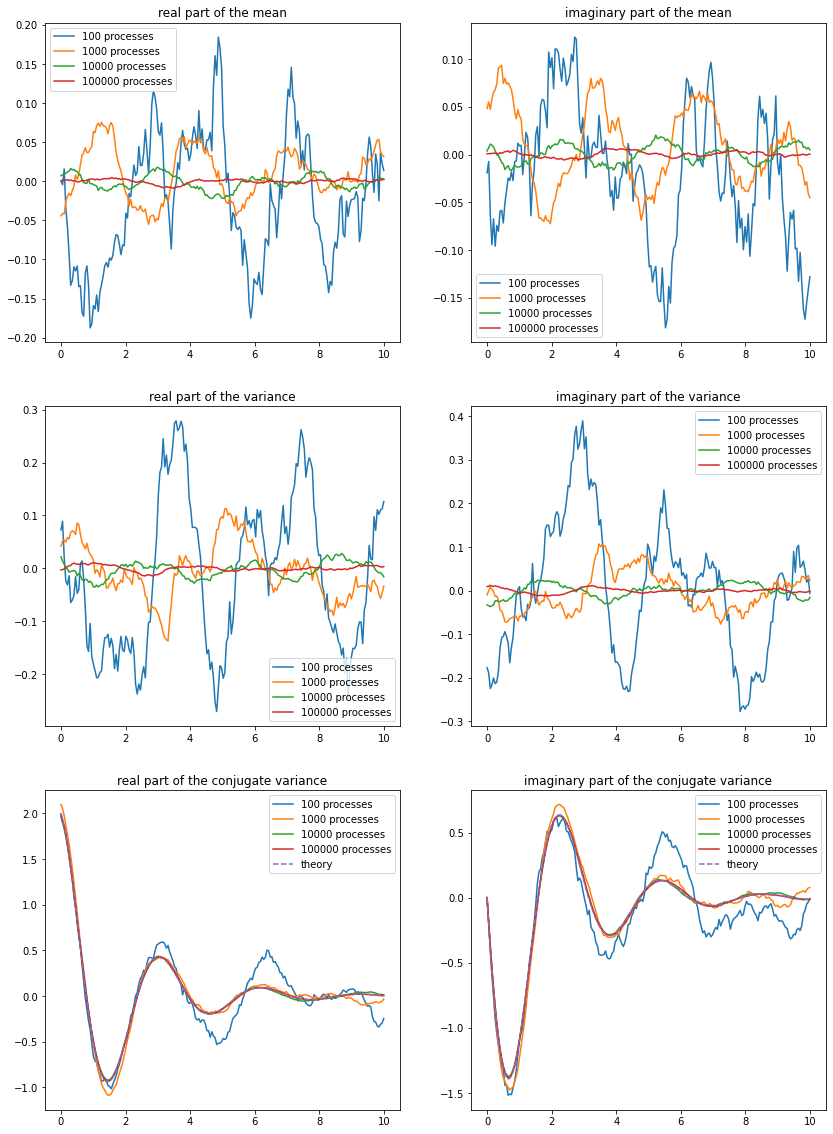

In [13]:
sample = lambda : generator.sample_process()
perform_noise_analysis(sample, ts, N_steps, [100, 1000, 10000, 100000], g, w, False)

Mean and Mean of variance approach zero. Mean of conjugate variances matches the desired variance very well! This method is also **a lot** faster than the multivariate gaussian method (~ 800 times faster)

# Generating noise for a BCF with multiple modes

In this section we will repeat the same experiment, but with a bath correlation function consisting of multiple bath modes. For this, we will use the debye spectral density at a temperature $\beta = 50$. We will use here the same coefficients as in the first example of the HOMPS paper, $\eta = 0.5$ and $\gamma = 0.35$.

In [16]:
N_terms = 1000
T = 1/50
gamma = 0.5
eta = 0.35
g, w = debye_spectral_density.get_debye_coefficients(N_terms, T, gamma, eta)

In [17]:
N_steps = 200
ts = np.linspace(t_start, t_stop, N_steps)

In [20]:
alpha = lambda tau: bath_correlation_function.alpha(tau, g, w)
generator = noise_generator.ColoredNoiseGenerator_FourierFiltering(alpha, t_start, t_stop)
generator.initialize(N_steps)

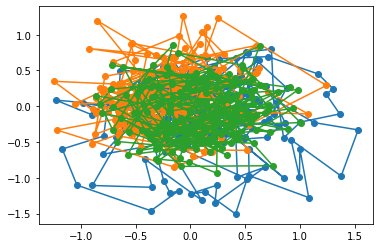

In [21]:
N_samples = 3
for _ in range(N_samples):
    process = generator.sample_process()
    plt.plot(np.real(process), np.imag(process), "o-")
plt.show()

finished generating 100 samples in 0.003998279571533203 seconds!
finished generating 1000 samples in 0.040293216705322266 seconds!
finished generating 10000 samples in 0.37808728218078613 seconds!
finished generating 100000 samples in 3.6659634113311768 seconds!
Starting analysis ...


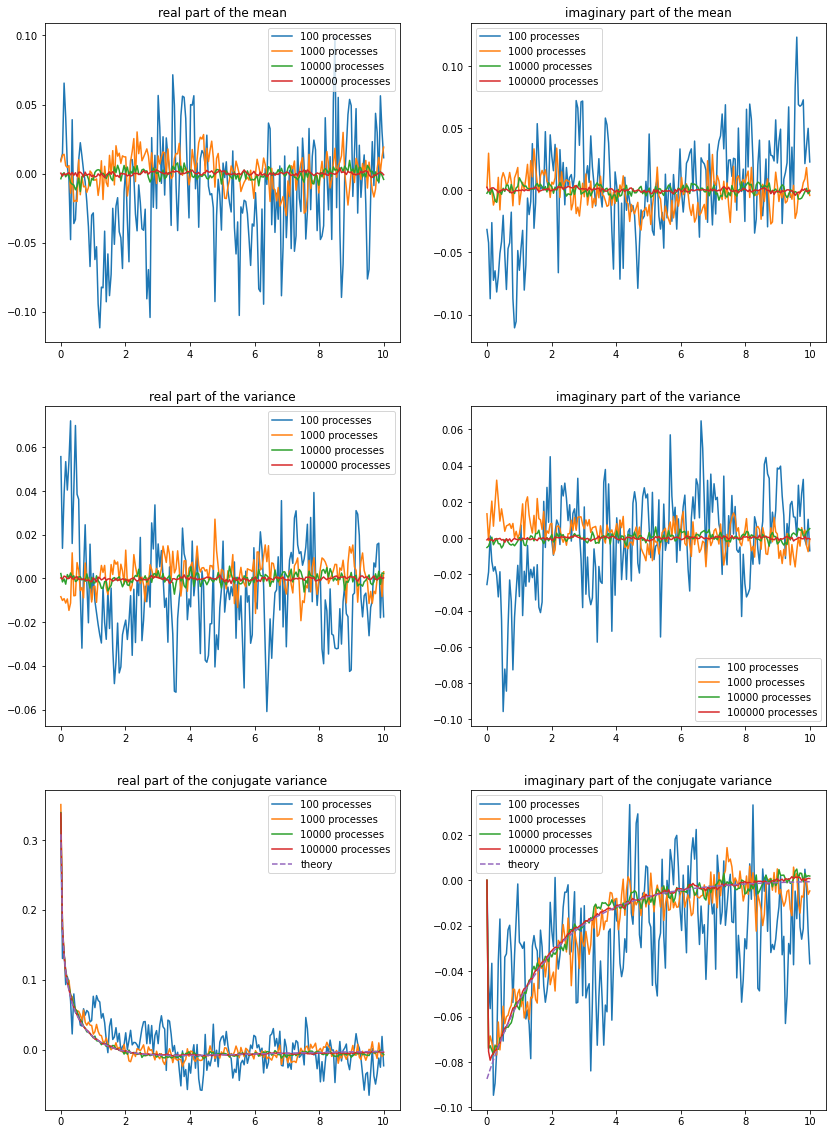

In [22]:
sample = lambda : generator.sample_process()
perform_noise_analysis(sample, ts, N_steps, [100, 1000, 10000, 100000], g, w, False)

# Sum approximation

In [23]:
def alpha(taus, J, beta, N, w_cut):
    integrand = lambda w, tau : J(w) * (1/np.tanh(w*beta/2)*np.cos(w*tau) - 1j*np.sin(w*tau))
    wj = (np.arange(N, dtype=float) + 0.5)*dw
    return np.array([np.sum(integrand(wj, tau))/np.pi*dw for tau in taus])

### high T, low damping

In [24]:
t_start = 0
t_stop = 10
N_steps = 200
beta = 0.5
gamma = 0.25
T = 1/beta
eta = 0.5
ts = np.linspace(t_start, t_stop, N_steps)

In [25]:
N = 10000
w_cut = 500
dw = w_cut / N

In [26]:
J = lambda w : debye_spectral_density.debye_spectral_density(w, eta, gamma)
alpha_theory = alpha(ts, J, beta, N, w_cut)

In [27]:
generator = noise_generator.ColoredNoiseGenerator_SumApprox(J, t_start, t_stop, N, w_cut, beta)
generator.initialize(N_steps)

In [28]:
N_samples_list = [100, 1000]#, 10000]

In [29]:
processes = []
for N_samples in N_samples_list:
    process = np.empty((N_samples, N_steps), dtype=complex)
    for n in tqdm(range(N_samples)):
        process[n, :] = generator.sample_process()
    processes.append(process)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

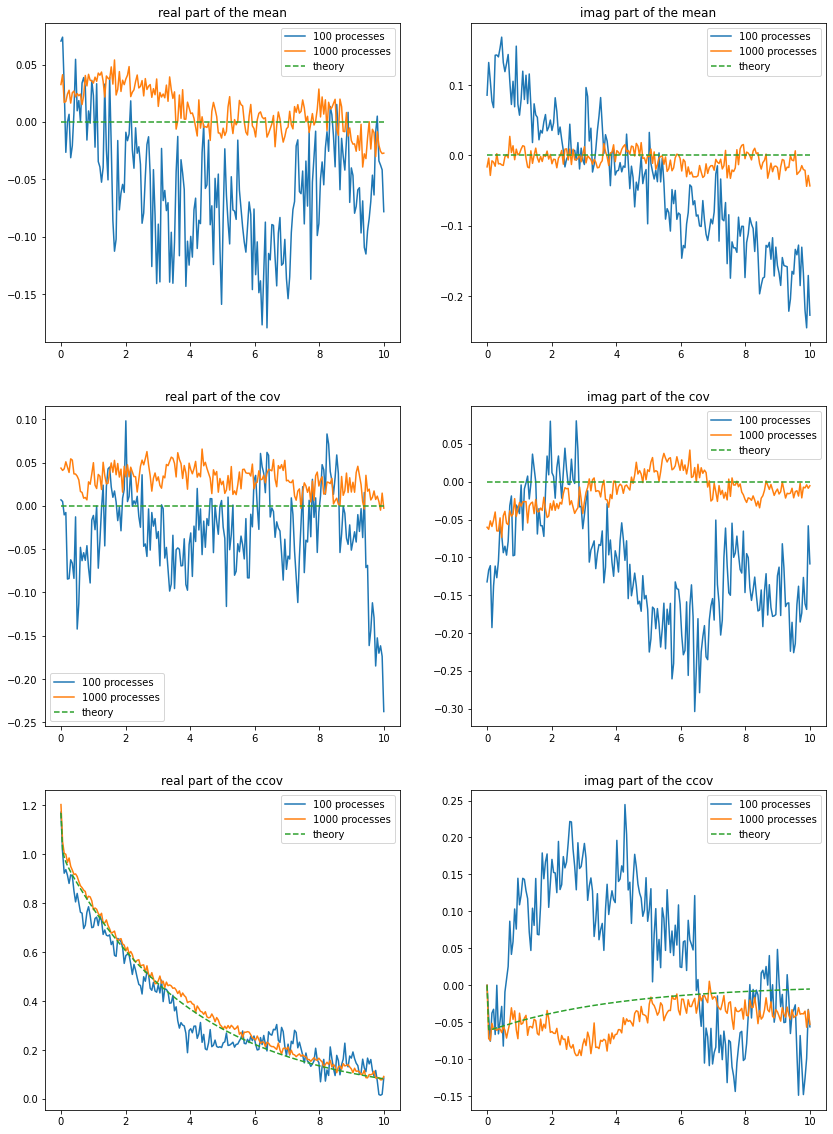

In [30]:
fig, axarray = plt.subplots(3, 2, figsize=(14, 20))
# plot mean
for i, N_samples in enumerate(N_samples_list):
    mean = np.mean(processes[i], axis=0)
    axarray[0][0].plot(ts, np.real(mean), label=str(N_samples)+" processes")
    axarray[0][1].plot(ts, np.imag(mean), label=str(N_samples)+" processes")
    # plot covariance
    valueAtZero = processes[i][:, 0]
    cov = np.mean(processes[i] * valueAtZero[:, np.newaxis], axis=0) # (N_samples, N_steps) * (N_samples, 1)
    axarray[1][0].plot(ts, np.real(cov), label=str(N_samples)+" processes")
    axarray[1][1].plot(ts, np.imag(cov), label=str(N_samples)+" processes")
    # plot conjugate covariance
    valueAtZero = np.conj(processes[i][:, 0])
    ccov = np.mean(processes[i] * valueAtZero[:, np.newaxis], axis=0)
    axarray[2][0].plot(ts, np.real(ccov), label=str(N_samples)+" processes")
    axarray[2][1].plot(ts, np.imag(ccov), label=str(N_samples)+" processes")
axarray[0][0].plot(ts, np.zeros(ts.shape), "--", label="theory")
axarray[0][0].legend()
axarray[0][0].set_title("real part of the mean")
axarray[0][1].plot(ts, np.zeros(ts.shape), "--", label="theory")
axarray[0][1].legend()
axarray[0][1].set_title("imag part of the mean")
axarray[1][0].plot(ts, np.zeros(ts.shape), "--", label="theory")
axarray[1][0].legend()
axarray[1][0].set_title("real part of the cov")
axarray[1][1].plot(ts, np.zeros(ts.shape), "--", label="theory")
axarray[1][1].legend()
axarray[1][1].set_title("imag part of the cov")
axarray[2][0].plot(ts, np.real(alpha_theory), "--", label="theory")
axarray[2][0].legend()
axarray[2][0].set_title("real part of the ccov")
axarray[2][1].plot(ts, np.imag(alpha_theory), "--", label="theory")
axarray[2][1].legend()
axarray[2][1].set_title("imag part of the ccov")
plt.show()

### low T, high damping

In [31]:
t_start = 0
t_stop = 10
N_steps = 200
beta = 50
gamma = 5
T = 1/beta
eta = 0.5
ts = np.linspace(t_start, t_stop, N_steps)

In [32]:
N = 10000
w_cut = 500
dw = w_cut / N

In [33]:
J = lambda w : debye_spectral_density.debye_spectral_density(w, eta, gamma)
alpha_theory = alpha(ts, J, beta, N, w_cut)

In [34]:
generator = noise_generator.ColoredNoiseGenerator_SumApprox(J, t_start, t_stop, N, w_cut, beta)
generator.initialize(N_steps)

In [35]:
N_samples_list = [100, 1000]#, 10000]

In [36]:
processes = []
for N_samples in N_samples_list:
    process = np.empty((N_samples, N_steps), dtype=complex)
    for n in tqdm(range(N_samples)):
        process[n, :] = generator.sample_process()
    processes.append(process)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

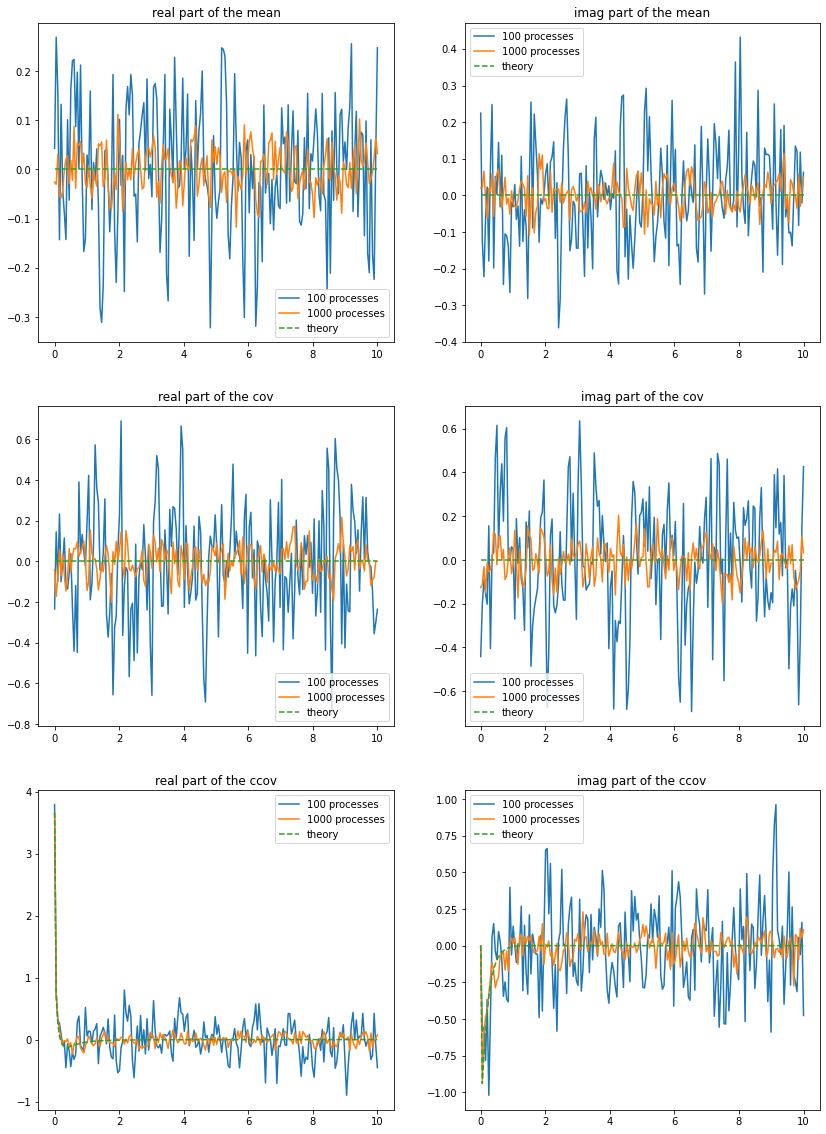

In [37]:
fig, axarray = plt.subplots(3, 2, figsize=(14, 20))
# plot mean
for i, N_samples in enumerate(N_samples_list):
    mean = np.mean(processes[i], axis=0)
    axarray[0][0].plot(ts, np.real(mean), label=str(N_samples)+" processes")
    axarray[0][1].plot(ts, np.imag(mean), label=str(N_samples)+" processes")
    # plot covariance
    valueAtZero = processes[i][:, 0]
    cov = np.mean(processes[i] * valueAtZero[:, np.newaxis], axis=0) # (N_samples, N_steps) * (N_samples, 1)
    axarray[1][0].plot(ts, np.real(cov), label=str(N_samples)+" processes")
    axarray[1][1].plot(ts, np.imag(cov), label=str(N_samples)+" processes")
    # plot conjugate covariance
    valueAtZero = np.conj(processes[i][:, 0])
    ccov = np.mean(processes[i] * valueAtZero[:, np.newaxis], axis=0)
    axarray[2][0].plot(ts, np.real(ccov), label=str(N_samples)+" processes")
    axarray[2][1].plot(ts, np.imag(ccov), label=str(N_samples)+" processes")
axarray[0][0].plot(ts, np.zeros(ts.shape), "--", label="theory")
axarray[0][0].legend()
axarray[0][0].set_title("real part of the mean")
axarray[0][1].plot(ts, np.zeros(ts.shape), "--", label="theory")
axarray[0][1].legend()
axarray[0][1].set_title("imag part of the mean")
axarray[1][0].plot(ts, np.zeros(ts.shape), "--", label="theory")
axarray[1][0].legend()
axarray[1][0].set_title("real part of the cov")
axarray[1][1].plot(ts, np.zeros(ts.shape), "--", label="theory")
axarray[1][1].legend()
axarray[1][1].set_title("imag part of the cov")
axarray[2][0].plot(ts, np.real(alpha_theory), "--", label="theory")
axarray[2][0].legend()
axarray[2][0].set_title("real part of the ccov")
axarray[2][1].plot(ts, np.imag(alpha_theory), "--", label="theory")
axarray[2][1].legend()
axarray[2][1].set_title("imag part of the ccov")
plt.show()